In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
pd.set_option('display.max_columns', 50)


# EDA, Data cleaning, Feature Engineering

## ug_fact_reading_result

In [2]:
df =  pd.read_excel('../../raw_data/Philippines CuC Data - 2024 10 03.xlsx', sheet_name='_fact_reading_result')
df.head()

,ChildrenId,ResultBaseline,ResultRound1,ResultRound2,ResultRound3,ResultEndline,Baseline to Round 1,Round 1 to Round 2,Round 2 to Round 3,Round 2 to Endline,Baseline to Endline - Group,Completing Result Baseline to Endline-Story/Comprehension Level,SchoolId,AcademicYearId,Year,District,Gender,Baseline to Endline - Type,ComprehensionAchieved,StoryAchieved,BatchCycle,AcademicYearName
0,2876,Beginner,Beginner,Beginner,NaN,Beginner,Stayed The Same,Stayed The Same,NaN,Stayed The Same,Stayed The Same,False,97,6,2023,Malapatan,Male,No Change,False,False,Batch 1-Cycle 1,2023-Sarangani-Batch 1-Cycle 1
1,2248,Beginner,Beginner,Beginner,NaN,Beginner,Stayed The Same,Stayed The Same,NaN,Stayed The Same,Stayed The Same,False,73,6,2023,Kiamba,Male,No Change,False,False,Batch 1-Cycle 1,2023-Sarangani-Batch 1-Cycle 1
2,2176,Beginner,Beginner,Beginner,NaN,Beginner,Stayed The Same,Stayed The Same,NaN,Stayed The Same,Stayed The Same,False,68,6,2023,Alabel,Male,No Change,False,False,Batch 1-Cycle 1,2023-Sarangani-Batch 1-Cycle 1
3,2861,Beginner,Beginner,Beginner,NaN,Beginner,Stayed The Same,Stayed The Same,NaN,Stayed The Same,Stayed The Same,False,97,6,2023,Malapatan,Male,No Change,False,False,Batch 1-Cycle 1,2023-Sarangani-Batch 1-Cycle 1
4,2865,Beginner,Beginner,Beginner,NaN,Beginner,Stayed The Same,Stayed The Same,NaN,Stayed The Same,Stayed The Same,False,97,6,2023,Malapatan,Male,No Change,False,False,Batch 1-Cycle 1,2023-Sarangani-Batch 1-Cycle 1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397 entries, 0 to 2396
Data columns (total 22 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   ChildrenId                                                       2397 non-null   int64  
 1   ResultBaseline                                                   2354 non-null   object 
 2   ResultRound1                                                     2029 non-null   object 
 3   ResultRound2                                                     2033 non-null   object 
 4   ResultRound3                                                     0 non-null      float64
 5   ResultEndline                                                    2220 non-null   object 
 6   Baseline to Round 1                                              2019 non-null   object 
 7   Round 1 to Round 2                        

In [4]:
df['Baseline to Endline - Group'].value_counts()

Baseline to Endline - Group
Increase           1671
Stayed The Same     500
Decrease             28
Name: count, dtype: int64

In [5]:
def unique_vals(df, only_categorical_cols = False, only_object = False):
    res = pd.DataFrame()
    cols = []
    nunique = []
    unique = []
    datatype = []
    num_of_nan = []
    for column in df:
        cols.append(column)
        nunique.append(df[column].nunique() )
        unique.append( df[column].unique() )
        datatype.append(df[column].dtype)
        num_of_nan.append(df[column].isnull().sum())
        
    
    res['col_name'] = cols
    res['number_of_unique_values'] = nunique
    res['unique_values'] = unique
    res['dtype'] = datatype
    res['number_of_nan'] = num_of_nan

    if only_categorical_cols and only_object:
        res = res[res['dtype']=='object']
        return res[res['number_of_unique_values']<500]

    if only_categorical_cols:
        return res[res['number_of_unique_values']<500]

    if only_object:
        return res[res['dtype']=='object']


    return res.sort_values('number_of_unique_values')


# drop columns where 70% of data is nan
df = df.dropna(thresh=len(df) * 0.3, axis=1)

# since Baseline_Endline column is our target delete NAN values:
df = df.dropna(subset=['Baseline to Endline - Group'])
unique_vals(df)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
12,Year,1,[2023],int64,0
9,Completing Result Baseline to Endline-Story/Co...,2,"[False, True]",bool,0
17,StoryAchieved,2,"[False, True]",bool,0
16,ComprehensionAchieved,2,"[False, True]",bool,0
14,Gender,2,"[Male, Female]",object,0
11,AcademicYearId,2,"[6, 7]",int64,0
18,BatchCycle,2,"[Batch 1-Cycle 1, Batch 2-Cycle 1]",object,0
19,AcademicYearName,2,"[2023-Sarangani-Batch 1-Cycle 1, 2023-Sarangan...",object,0
8,Baseline to Endline - Group,3,"[Stayed The Same, Increase, Decrease]",object,0
6,Round 1 to Round 2,3,"[Stayed The Same, Increase, nan, Decrease]",object,450


In [6]:
df.shape

(2199, 20)

In [7]:
# Other columns are string object type, filling nan values by 0
df = df.fillna('0')

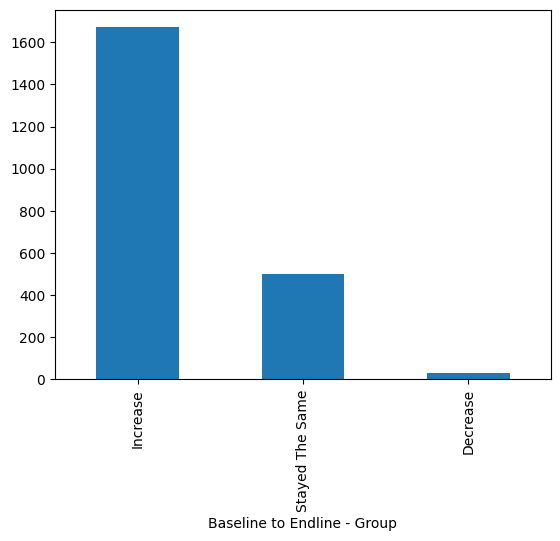

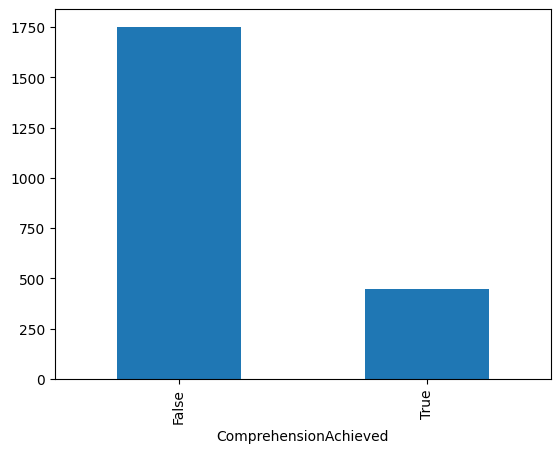

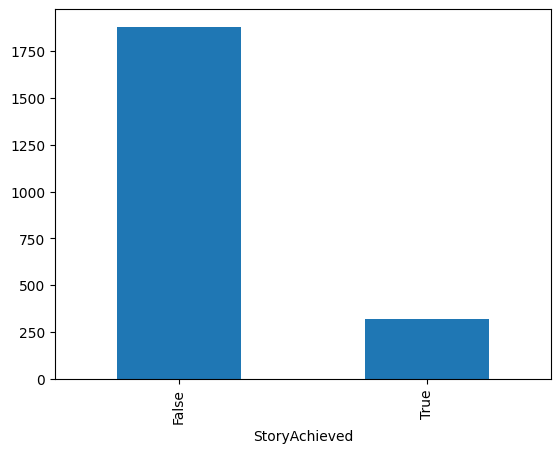

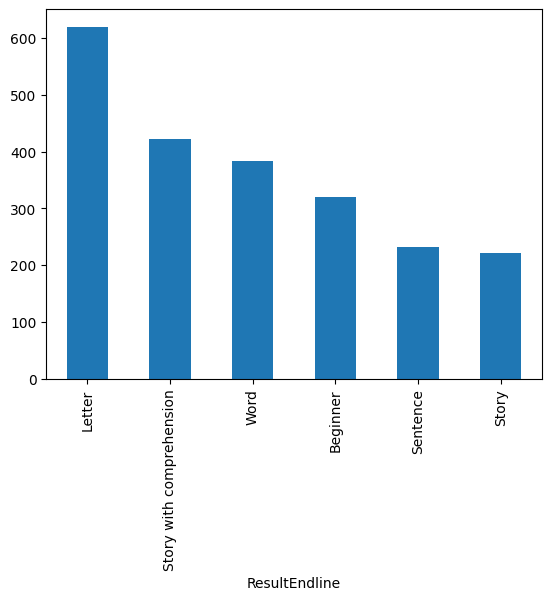

In [8]:
tcols = ['Baseline to Endline - Group',  'ComprehensionAchieved', 'StoryAchieved', 'ResultEndline']
for col in tcols:
    df[f'{col}'].value_counts().plot(kind='bar')
    plt.show()


In [9]:
df.groupby(['Baseline to Endline - Group', 'Gender'])['Gender'].count()
# Same for both gender

Baseline to Endline - Group  Gender
Decrease                     Female      7
                             Male       21
Increase                     Female    681
                             Male      990
Stayed The Same              Female    156
                             Male      344
Name: Gender, dtype: int64

In [10]:
df.groupby(['Baseline to Endline - Group', 'Gender'])['Baseline to Endline - Group'].count()

Baseline to Endline - Group  Gender
Decrease                     Female      7
                             Male       21
Increase                     Female    681
                             Male      990
Stayed The Same              Female    156
                             Male      344
Name: Baseline to Endline - Group, dtype: int64

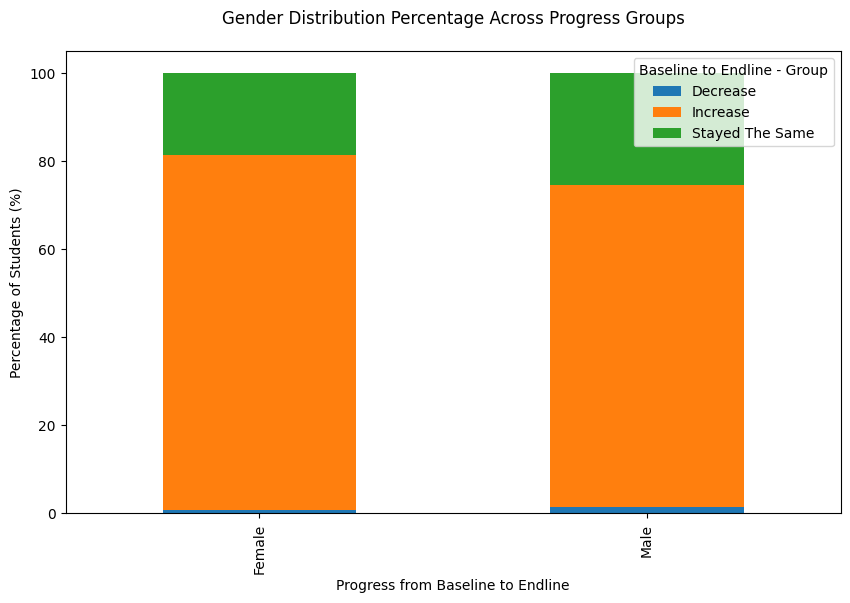

In [11]:
progress_by_gender = df.groupby(['Gender', 'Baseline to Endline - Group'])['Gender'].count().unstack()
progress_by_gender_pct = progress_by_gender.div(progress_by_gender.sum(axis=1), axis=0) * 100

# Create a stacked bar plot
ax = progress_by_gender_pct.plot(kind='bar', stacked=True, 
                                figsize=(10, 6)) 

# Customize the plot
plt.title('Gender Distribution Percentage Across Progress Groups', pad=20)
plt.xlabel('Progress from Baseline to Endline')
plt.ylabel('Percentage of Students (%)')
plt.show()


In [12]:
print(df.groupby(['AcademicYearId', 'AcademicYearName']).size())

AcademicYearId  AcademicYearName              
6               2023-Sarangani-Batch 1-Cycle 1    1166
7               2023-Sarangani-Batch 2-Cycle 1    1033
dtype: int64


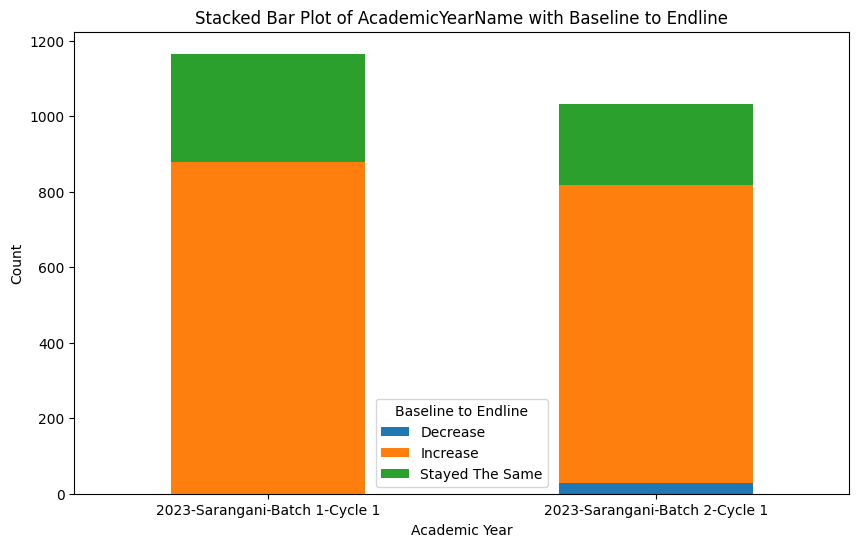

In [13]:
counts = df.groupby(['AcademicYearName', 'Baseline to Endline - Group']).size().unstack()

counts.plot(kind='bar', stacked=True, figsize=(10,6))

plt.title('Stacked Bar Plot of AcademicYearName with Baseline to Endline')
plt.xlabel('Academic Year')
plt.ylabel('Count')

plt.legend(title='Baseline to Endline')
plt.xticks(rotation=0)
plt.show()
# for all academic years the level is increased

## ug_fact_student_registrations

In [14]:
df2 = pd.read_excel('../../raw_data/Philippines CuC Data - 2024 10 03.xlsx', sheet_name='_fact_student_registrations').drop_duplicates()
df2.head()

,Gender,DeleteReasonId,AcademicYearFull,AcademicTermDetailsId,AcademicYearId,ChildID,SchoolID,ClassID,DeleteReason,StateID,Batch,Cycle,Grade,Age,EoR1,EoR2,EoR3/Endline,ParentTypeId,ParentType,DistrictID
0,Female,NaN,2023-Sarangani-Batch 1-Cycle 1,70,6,2706,49,344,NaN,1,Batch 1,Cycle 1,Grade 4,13,Yes,Yes,Yes,NaN,NaN,5
1,Male,NaN,2023-Sarangani-Batch 1-Cycle 1,70,6,2708,49,344,NaN,1,Batch 1,Cycle 1,Grade 4,13,Yes,Yes,Yes,NaN,NaN,5
2,Male,NaN,2023-Sarangani-Batch 1-Cycle 1,70,6,2715,49,344,NaN,1,Batch 1,Cycle 1,Grade 4,13,Yes,Yes,Yes,NaN,NaN,5
3,Male,NaN,2023-Sarangani-Batch 1-Cycle 1,79,6,2799,57,262,NaN,1,Batch 1,Cycle 1,Grade 4,13,Yes,Yes,Yes,NaN,NaN,5
4,Male,NaN,2023-Sarangani-Batch 1-Cycle 1,90,6,3102,59,355,NaN,1,Batch 1,Cycle 1,Grade 4,13,Yes,Yes,Yes,NaN,NaN,5


In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2468 entries, 0 to 2499
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 2468 non-null   object 
 1   DeleteReasonId         1186 non-null   float64
 2   AcademicYearFull       2468 non-null   object 
 3   AcademicTermDetailsId  2468 non-null   int64  
 4   AcademicYearId         2468 non-null   int64  
 5   ChildID                2468 non-null   int64  
 6   SchoolID               2468 non-null   int64  
 7   ClassID                2468 non-null   int64  
 8   DeleteReason           231 non-null    object 
 9   StateID                2468 non-null   int64  
 10  Batch                  2468 non-null   object 
 11  Cycle                  2468 non-null   object 
 12  Grade                  2468 non-null   object 
 13  Age                    2468 non-null   int64  
 14  EoR1                   2468 non-null   object 
 15  EoR2     

In [16]:
unique_vals(df2)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
9,StateID,1,[1],int64,0
11,Cycle,1,[Cycle 1],object,0
16,EoR3/Endline,2,"[Yes, No]",object,0
15,EoR2,2,"[Yes, No]",object,0
14,EoR1,2,"[Yes, No]",object,0
10,Batch,2,"[Batch 1, Batch 2]",object,0
0,Gender,2,"[Female, Male]",object,0
4,AcademicYearId,2,"[6, 7]",int64,0
2,AcademicYearFull,2,"[2023-Sarangani-Batch 1-Cycle 1, 2023-Sarangan...",object,0
18,ParentType,3,"[nan, Mother, Guardian, Father]",object,1497


In [17]:
df2.drop(['StateID', 'Cycle'], axis=1, inplace=True)

In [18]:
df2.groupby(['AcademicYearFull','AcademicYearId']).size()

AcademicYearFull                AcademicYearId
2023-Sarangani-Batch 1-Cycle 1  6                 1210
2023-Sarangani-Batch 2-Cycle 1  7                 1258
dtype: int64

In [19]:
print(df2.groupby(['DeleteReasonId', 'DeleteReason']).size())
print()
print(df2.groupby(['ParentType', 'ParentTypeId']).size())

DeleteReasonId  DeleteReason
1.0             Transferred      7
2.0             Drop Out        88
6.0             Error Input     63
14.0            Graduated       66
15.0            Duplicate        7
dtype: int64

ParentType  ParentTypeId
Father      1.0             271
Guardian    3.0              81
Mother      2.0             619
dtype: int64


In [20]:
# for ParentTypeId fill nan data by 0
df2.loc[:,'ParentTypeId'] = df2['ParentTypeId'].fillna(0)


# for DeleteReasonId 0.0 == NaN
df2.loc[:, 'DeleteReasonId'] = df2['DeleteReasonId'].fillna(0)

In [21]:
df2.columns

Index(['Gender', 'DeleteReasonId', 'AcademicYearFull', 'AcademicTermDetailsId',
       'AcademicYearId', 'ChildID', 'SchoolID', 'ClassID', 'DeleteReason',
       'Batch', 'Grade', 'Age', 'EoR1', 'EoR2', 'EoR3/Endline', 'ParentTypeId',
       'ParentType', 'DistrictID'],
      dtype='object')

In [22]:
# Some columns are numeric representation of object columns, taken the numeric version of that features
# and some columns already exists in other sheets
cols2 = [ 'DeleteReasonId', 'AcademicTermDetailsId','AcademicYearId',
'ChildID', 'ClassID', 'Batch',  'Grade', 'Age', 'EoR1', 'EoR2',
       'EoR3/Endline', 'ParentTypeId', 'DistrictID']
df2 = df2[cols2]
unique_vals(df2)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
2,AcademicYearId,2,"[6, 7]",int64,0
5,Batch,2,"[Batch 1, Batch 2]",object,0
8,EoR1,2,"[Yes, No]",object,0
9,EoR2,2,"[Yes, No]",object,0
10,EoR3/Endline,2,"[Yes, No]",object,0
6,Grade,4,"[Grade 4, Grade 5, Grade 6, Unknown]",object,0
11,ParentTypeId,4,"[0.0, 2.0, 3.0, 1.0]",float64,0
0,DeleteReasonId,6,"[0.0, 6.0, 2.0, 14.0, 15.0, 1.0]",float64,0
12,DistrictID,7,"[5, 7, 2, 3, 1, 4, 6]",int64,0
7,Age,12,"[13, 0, 8, 14, 15, 16, 17, 12, 11, 9, 10, 6]",int64,0


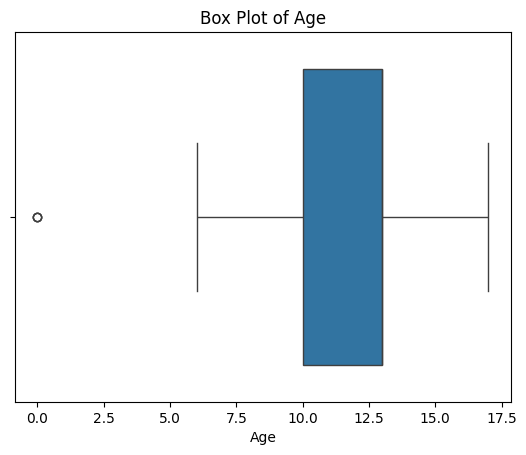

In [23]:
# Box plot of Age
sns.boxplot(data=df2, x='Age')
plt.title('Box Plot of Age')
plt.xlabel('Age')
# plt.ylabel('Baseline to Endline')
plt.show()


No outliers

In [24]:
# merge two sheets based on ChildID
merged_df = pd.merge(df, df2, 
                     left_on=['ChildrenId', 'AcademicYearId'], 
                     right_on=['ChildID', 'AcademicYearId'],
                       how='inner')

merged_df.drop('ChildID', axis=1, inplace=True)
merged_df.shape

(2216, 31)

In [25]:
unique_vals(merged_df)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
28,EoR3/Endline,1,[Yes],object,0
12,Year,1,[2023],int64,0
26,EoR1,2,"[Yes, No]",object,0
19,AcademicYearName,2,"[2023-Sarangani-Batch 1-Cycle 1, 2023-Sarangan...",object,0
18,BatchCycle,2,"[Batch 1-Cycle 1, Batch 2-Cycle 1]",object,0
17,StoryAchieved,2,"[False, True]",bool,0
16,ComprehensionAchieved,2,"[False, True]",bool,0
14,Gender,2,"[Male, Female]",object,0
11,AcademicYearId,2,"[6, 7]",int64,0
23,Batch,2,"[Batch 1, Batch 2]",object,0


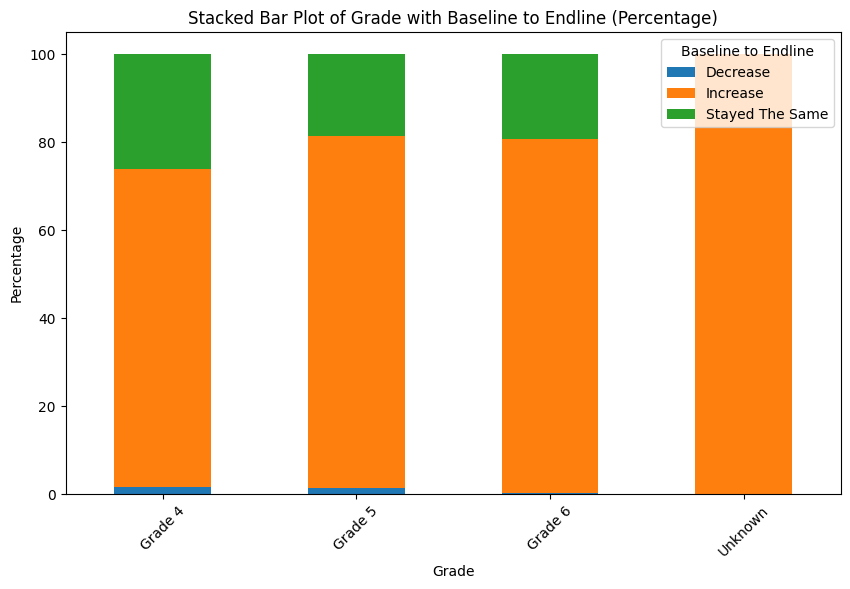

In [26]:

counts = merged_df.groupby(['Grade', 'Baseline to Endline - Group']).size().unstack()

# Calculate percentages
percentage = counts.divide(counts.sum(axis=1), axis=0) * 100

# Plot a stacked bar chart with percentages
percentage.plot(kind='bar', stacked=True, figsize=(10,6))

# Adding labels and title
plt.ylabel('Percentage')
plt.legend(title='Baseline to Endline')
plt.title('Stacked Bar Plot of Grade with Baseline to Endline (Percentage)')
plt.xticks(rotation=45)

# Display the plot
plt.show()

# for children whose class is unknown, level is deacreased

DeleteReasonId
0.0     2104
14.0      65
6.0       37
15.0       6
2.0        4
Name: count, dtype: int64


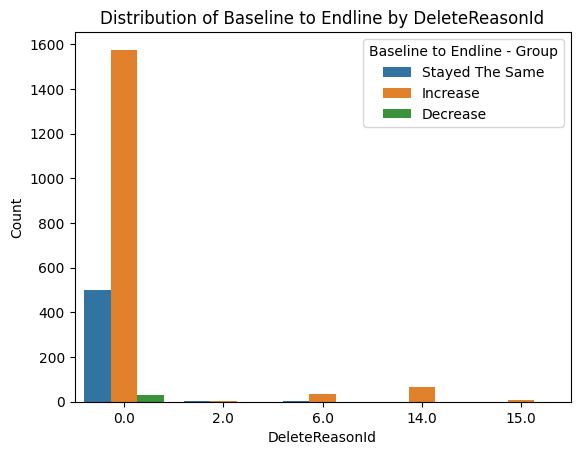

In [27]:
# Count of each ParentType
parent_counts = merged_df['DeleteReasonId'].value_counts()
print(parent_counts)

# Distribution of Baseline to Endline by ParentType
sns.countplot(data=merged_df, x='DeleteReasonId', hue='Baseline to Endline - Group')
plt.title('Distribution of Baseline to Endline by DeleteReasonId')
plt.ylabel('Count')
plt.show()

# No difference based on Parent type

The majority of students prefer not to provide a reason for dropping the course(#0).

ParentTypeId
0.0    1332
2.0     571
1.0     241
3.0      72
Name: count, dtype: int64


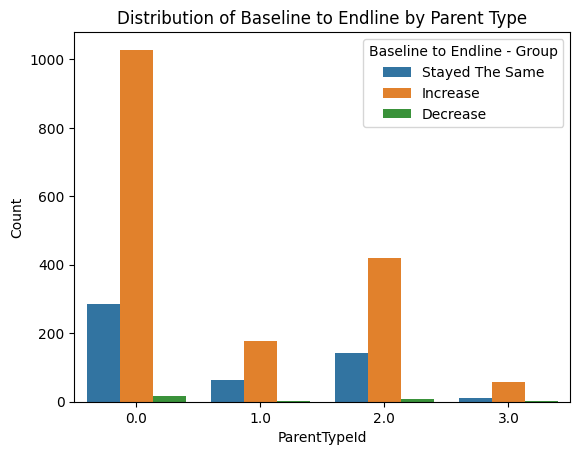

In [28]:
# Count of each ParentType
parent_counts = merged_df['ParentTypeId'].value_counts()
print(parent_counts)

# Distribution of Baseline to Endline by ParentType
sns.countplot(data=merged_df, x='ParentTypeId', hue='Baseline to Endline - Group')
plt.title('Distribution of Baseline to Endline by Parent Type')
plt.ylabel('Count')
plt.show()



There is no difference in the change in student achievement levels depending on the parent type.

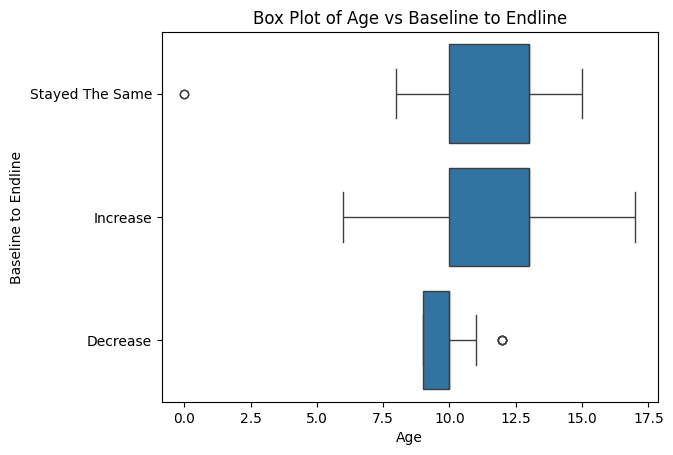

In [29]:
# Box plot of Age vs Baseline to Endline
sns.boxplot(data=merged_df, x='Age', y='Baseline to Endline - Group')
plt.title('Box Plot of Age vs Baseline to Endline')
plt.xlabel('Age')
plt.ylabel('Baseline to Endline')
plt.show()


Age range of Decreased level is lower than other levels

/var/folders/_f/s0xx4_bj711c1h8k9b5vjhgm0000gn/T/ipykernel_94544/4175731371.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = merged_df.groupby(['AgeGroup', 'Baseline to Endline - Group']).size().unstack()


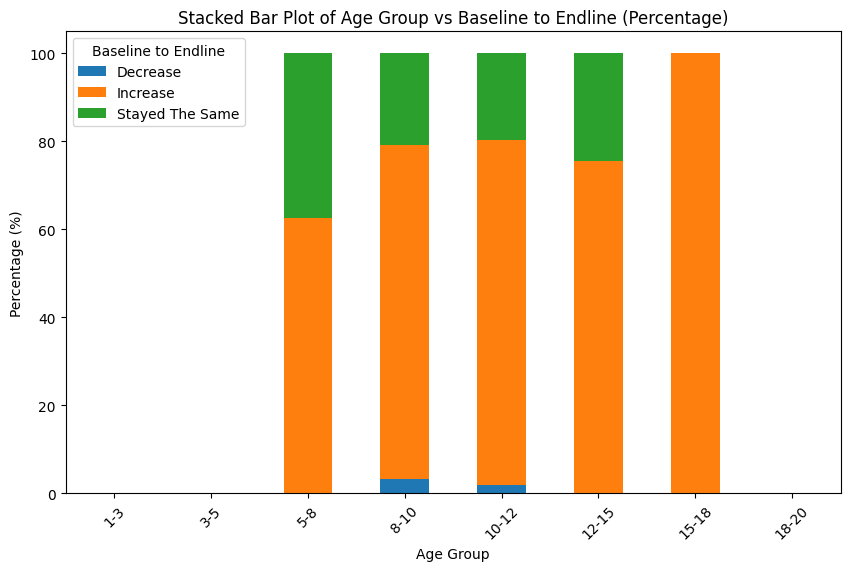

In [30]:
# # Binning Age into categories
bins = [1, 3, 5,8, 10, 12, 15, 18, 20]  # Adjust based on your data range
labels = ['1-3','3-5','5-8', '8-10', '10-12', '12-15', '15-18', '18-20']
merged_df['AgeGroup'] = pd.cut(merged_df['Age'], bins=bins, labels=labels)

# Group by AgeGroup and Baseline to Endline, then normalize to get percentages
counts = merged_df.groupby(['AgeGroup', 'Baseline to Endline - Group']).size().unstack()

# Convert the counts to percentages
percentage_counts = counts.div(counts.sum(axis=1), axis=0) * 100

# Create a stacked bar plot with percentages
percentage_counts.plot(kind='bar', stacked=True, figsize=(10,6))

plt.title('Stacked Bar Plot of Age Group vs Baseline to Endline (Percentage)')
plt.xlabel('Age Group')
plt.ylabel('Percentage (%)')
plt.legend(title='Baseline to Endline')
plt.xticks(rotation=45)
plt.show()

merged_df.drop('AgeGroup', axis=1, inplace=True)

The decrease rate among students aged 8-10 was higher than that of other age groups.

In [31]:
print(merged_df.groupby(['District', 'DistrictID']).size())
print(merged_df.groupby(['AcademicYearName', 'AcademicYearId']).size())

District   DistrictID
Alabel     1             386
Glan       7             333
Kiamba     2             315
Maasim     4             319
Maitum     6             189
Malapatan  3             282
Malungon   5             392
dtype: int64
AcademicYearName                AcademicYearId
2023-Sarangani-Batch 1-Cycle 1  6                 1164
2023-Sarangani-Batch 2-Cycle 1  7                 1052
dtype: int64


In [32]:
# merged_df.drop(['District', 'AcademicYearName'], axis=1, inplace=True)

## ug_fact_student_attendance

In [33]:
df3 = pd.read_excel(
    '../../raw_data/Philippines CuC Data - 2024 10 03.xlsx', 
    sheet_name='_fact_student_attendance',
    usecols=['ChildrenId',  'StudentIsPresent', 'AcademicYearId']
)
display(df3.head())
print(df3.shape)

,StudentIsPresent,ChildrenId,AcademicYearId
0,True,4508,7.0
1,True,4518,7.0
2,True,4497,7.0
3,True,4503,7.0
4,True,4513,7.0


(77205, 3)


In [34]:
# Calculate attendance rate
df3['AttendanceRate'] = df3.groupby('ChildrenId')['StudentIsPresent'].transform('mean')
df3.drop('StudentIsPresent', axis=1, inplace=True)
# Drop duplicated columns
df3 = df3.drop_duplicates()
df3.shape

(2375, 3)

In [35]:
unique_vals(df3)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
1,AcademicYearId,2,"[7.0, nan, 6.0]",float64,24
2,AttendanceRate,252,"[1.0, 0.7714285714285715, 0.7428571428571429, ...",float64,0
0,ChildrenId,2351,"[4508, 4518, 4497, 4503, 4513, 4499, 4511, 452...",int64,0


In [36]:
# merge two sheets based on ChildID
merged_df = pd.merge(merged_df, df3, 
                     left_on=['ChildrenId', 'AcademicYearId'], 
                     right_on=['ChildrenId', 'AcademicYearId'], 
                     how='inner')
merged_df.shape

(2190, 32)

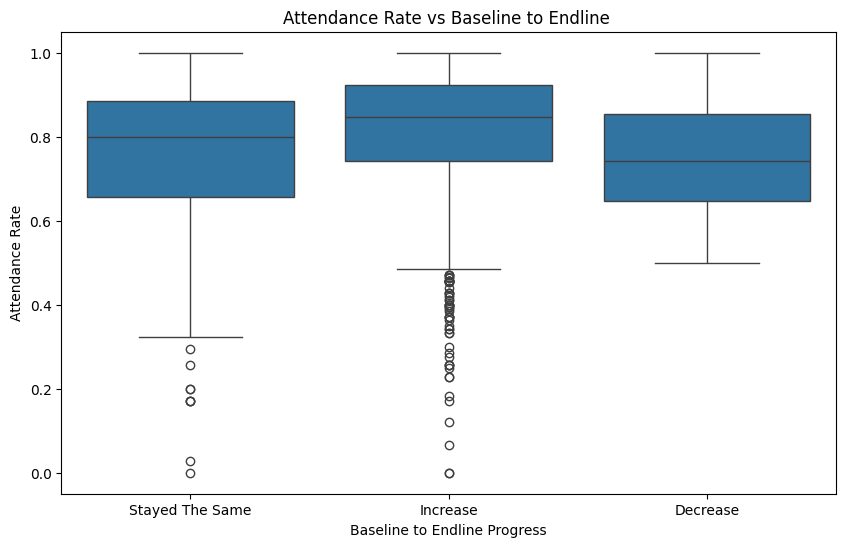

In [38]:
# Plot attendance rates for each baseline-to-endline transition
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='Baseline to Endline - Group', y='AttendanceRate')

# Add titles and labels
plt.title('Attendance Rate vs Baseline to Endline ')
plt.xlabel('Baseline to Endline Progress')
plt.ylabel('Attendance Rate')

plt.show()

In [35]:
merged_df.to_csv('data/merged_Ph.csv', index=True)
# merged_df.to_excel('data/merged_Ph_with_nans.xlsx', index=True)

AcademicYearId
6    1139
7    1051
Name: count, dtype: int64


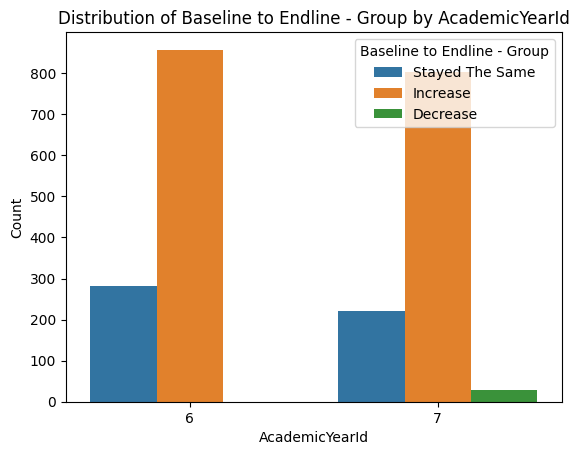

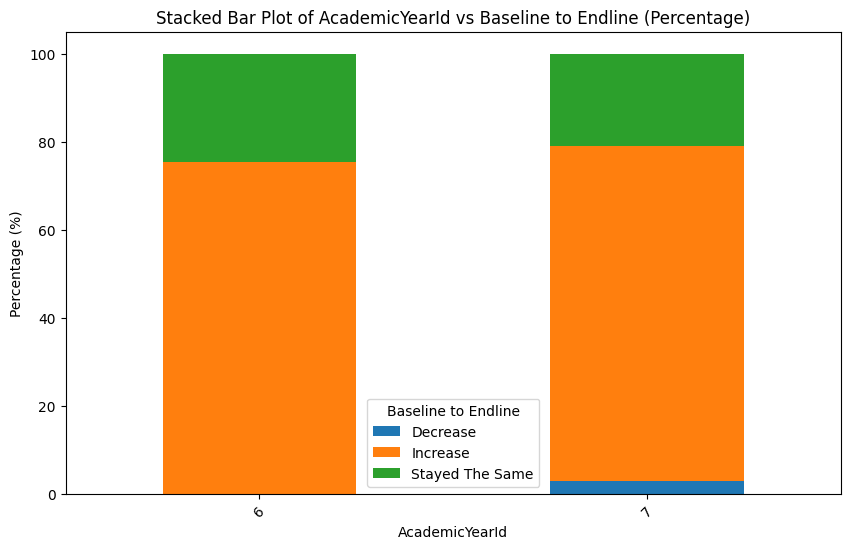

In [36]:
# Count of each ParentType
counts = merged_df['AcademicYearId'].value_counts()
print(counts)

# Distribution of Baseline to Endline by ParentType
sns.countplot(data=merged_df, x='AcademicYearId', hue='Baseline to Endline - Group')
plt.title('Distribution of Baseline to Endline - Group by AcademicYearId')
plt.ylabel('Count')
plt.show()


counts = merged_df.groupby(['AcademicYearId', 'Baseline to Endline - Group']).size().unstack()
# Convert the counts to percentages
percentage_counts = counts.div(counts.sum(axis=1), axis=0) * 100

# Create a stacked bar plot with percentages
percentage_counts.plot(kind='bar', stacked=True, figsize=(10,6))

plt.title('Stacked Bar Plot of AcademicYearId vs Baseline to Endline (Percentage)')
plt.xlabel('AcademicYearId')
plt.ylabel('Percentage (%)')
plt.legend(title='Baseline to Endline')
plt.xticks(rotation=45)
plt.show()

## additional data

In [37]:
df4 = pd.read_excel( '../../raw_data/Philippines - Additional Data - 2024 10 23.xlsx').drop_duplicates()
print(df4.shape)
df4.head()

(8794, 27)


,SchoolId,ClassName,ClassId,ChildrenId,ChildrenGender,ChildrenDateOfBirth,ChildrenAge,Safety Status Category,IsCUCSatisfied?,WillingnessInCUC?,BirthOrder,PrimaryCaregiver,LanguangeAtHome,AcademicYearId,SpendTimeWithFamily,CalmWhenStress,SomeoneToTalkWhenStress,TellFamilyWhenStress,FeelingSad,HowResolveProblem,WhoResolveProblem,OtherLanguangeAtHome,Year,Project,Cycle,AssessorID,DistrictID
0,43,NaN,NaN,2154,Unknown,NaN,NaN,Very Safe,10.0,Very Likely,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,Sarangani,1,118,1
1,43,NaN,NaN,2163,Unknown,NaN,NaN,Very Safe,10.0,Very Likely,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,Sarangani,1,118,1
2,43,NaN,NaN,2151,Unknown,NaN,NaN,Very Safe,10.0,Very Likely,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,Sarangani,1,118,1
3,43,NaN,NaN,2156,Unknown,NaN,NaN,Very Safe,10.0,Very Likely,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,Sarangani,1,118,1
4,43,NaN,NaN,2155,Unknown,NaN,NaN,Very Safe,10.0,Very Likely,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,Sarangani,1,118,1


In [38]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8794 entries, 0 to 9060
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SchoolId                 8794 non-null   int64  
 1   ClassName                2459 non-null   object 
 2   ClassId                  2459 non-null   float64
 3   ChildrenId               8794 non-null   int64  
 4   ChildrenGender           8794 non-null   object 
 5   ChildrenDateOfBirth      267 non-null    object 
 6   ChildrenAge              1208 non-null   float64
 7   Safety Status Category   5024 non-null   object 
 8   IsCUCSatisfied?          5023 non-null   float64
 9   WillingnessInCUC?        5023 non-null   object 
 10  BirthOrder               1073 non-null   object 
 11  PrimaryCaregiver         1073 non-null   object 
 12  LanguangeAtHome          1071 non-null   object 
 13  AcademicYearId           8794 non-null   int64  
 14  SpendTimeWithFamily      2124

In [39]:
unique_vals(df4)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
24,Cycle,1,[1],int64,0
23,Project,1,[Sarangani],object,0
22,Year,1,[2023],int64,0
13,AcademicYearId,2,"[6, 7]",int64,0
4,ChildrenGender,3,"[Unknown, Male, Female]",object,0
18,FeelingSad,3,"[nan, Yes, No, Refuse to answer]",object,7739
15,CalmWhenStress,3,"[nan, Yes, No, Refuse to answer]",object,7739
1,ClassName,4,"[nan, WORD, SENTENCE, LETTER, STORY]",object,6335
7,Safety Status Category,5,"[Very Safe, Safe, Neutral, nan, Un safe, Very ...",object,3770
9,WillingnessInCUC?,5,"[Very Likely, Likely, Not Likely at All, Not L...",object,3771


In [40]:
col_threshold = 0.85

# Drop columns where more than 95% of the data is NaN
df4 = df4.loc[:, df4.isnull().mean() < col_threshold]
print(df4.shape)
unique_vals(df4)

(8794, 19)


,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
16,Cycle,1,[1],int64,0
15,Project,1,[Sarangani],object,0
14,Year,1,[2023],int64,0
8,AcademicYearId,2,"[6, 7]",int64,0
4,ChildrenGender,3,"[Unknown, Male, Female]",object,0
1,ClassName,4,"[nan, WORD, SENTENCE, LETTER, STORY]",object,6335
5,Safety Status Category,5,"[Very Safe, Safe, Neutral, nan, Un safe, Very ...",object,3770
7,WillingnessInCUC?,5,"[Very Likely, Likely, Not Likely at All, Not L...",object,3771
9,SpendTimeWithFamily,6,"[nan, Yes, Refuse to answer, No, 1. Yes, 2. No...",object,6670
13,WhoResolveProblem,6,"[nan, Yes, No, Refuse to answer, 1. Yes, 2. No...",object,6668


In [41]:
df4.columns

Index(['SchoolId', 'ClassName', 'ClassId', 'ChildrenId', 'ChildrenGender',
       'Safety Status Category', 'IsCUCSatisfied?', 'WillingnessInCUC?',
       'AcademicYearId', 'SpendTimeWithFamily', 'SomeoneToTalkWhenStress',
       'TellFamilyWhenStress', 'HowResolveProblem', 'WhoResolveProblem',
       'Year', 'Project', 'Cycle', 'AssessorID', 'DistrictID'],
      dtype='object')

In [42]:
# useful columns
cols4 = ['ChildrenId', 'Safety Status Category',
       'IsCUCSatisfied?', 'WillingnessInCUC?', 
       'SpendTimeWithFamily', 
       'TellFamilyWhenStress', 'HowResolveProblem',
       'WhoResolveProblem', 'AssessorID', 'AcademicYearId']
df4 = df4[cols4]
unique_vals(df4)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
9,AcademicYearId,2,"[6, 7]",int64,0
1,Safety Status Category,5,"[Very Safe, Safe, Neutral, nan, Un safe, Very ...",object,3770
3,WillingnessInCUC?,5,"[Very Likely, Likely, Not Likely at All, Not L...",object,3771
4,SpendTimeWithFamily,6,"[nan, Yes, Refuse to answer, No, 1. Yes, 2. No...",object,6670
5,TellFamilyWhenStress,6,"[nan, Yes, No, Refuse to answer, 1. Yes, 2. No...",object,6680
6,HowResolveProblem,6,"[nan, Yes, No, Refuse to answer, 2. No, 3. Don...",object,6669
7,WhoResolveProblem,6,"[nan, Yes, No, Refuse to answer, 1. Yes, 2. No...",object,6668
2,IsCUCSatisfied?,10,"[10.0, nan, 8.0, 6.0, 9.0, 7.0, 5.0, 4.0, 2.0,...",float64,3771
8,AssessorID,591,"[118, 29, 14, 1, 35, 119, 120, 4, 25, 28, 40, ...",int64,0
0,ChildrenId,2397,"[2154, 2163, 2151, 2156, 2155, 2149, 2166, 215...",int64,0


In [43]:
df4['IsCUCSatisfied?'].value_counts()

IsCUCSatisfied?
10.0    2986
9.0      694
8.0      541
5.0      337
7.0      205
6.0      120
1.0       58
4.0       40
2.0       37
3.0        5
Name: count, dtype: int64

In [44]:
df4.fillna({'IsCUCSatisfied?': 0}, inplace=True)
unique_vals(df4)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
9,AcademicYearId,2,"[6, 7]",int64,0
1,Safety Status Category,5,"[Very Safe, Safe, Neutral, nan, Un safe, Very ...",object,3770
3,WillingnessInCUC?,5,"[Very Likely, Likely, Not Likely at All, Not L...",object,3771
4,SpendTimeWithFamily,6,"[nan, Yes, Refuse to answer, No, 1. Yes, 2. No...",object,6670
5,TellFamilyWhenStress,6,"[nan, Yes, No, Refuse to answer, 1. Yes, 2. No...",object,6680
6,HowResolveProblem,6,"[nan, Yes, No, Refuse to answer, 2. No, 3. Don...",object,6669
7,WhoResolveProblem,6,"[nan, Yes, No, Refuse to answer, 1. Yes, 2. No...",object,6668
2,IsCUCSatisfied?,11,"[10.0, 0.0, 8.0, 6.0, 9.0, 7.0, 5.0, 4.0, 2.0,...",float64,0
8,AssessorID,591,"[118, 29, 14, 1, 35, 119, 120, 4, 25, 28, 40, ...",int64,0
0,ChildrenId,2397,"[2154, 2163, 2151, 2156, 2155, 2149, 2166, 215...",int64,0


In [45]:
df4.fillna('0', inplace=True)


In [46]:
# merge two sheets based on ChildID
merged_df = pd.merge(merged_df, df4, 
                     left_on=['ChildrenId', 'AcademicYearId'], 
                     right_on=['ChildrenId', 'AcademicYearId'], how='inner')

merged_df.shape

(8273, 40)

In [47]:
unique_vals(merged_df)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
28,EoR3/Endline,1,[Yes],object,0
12,Year,1,[2023],int64,0
19,AcademicYearName,2,"[2023-Sarangani-Batch 1-Cycle 1, 2023-Sarangan...",object,0
27,EoR2,2,"[Yes, No]",object,0
26,EoR1,2,"[Yes, No]",object,0
23,Batch,2,"[Batch 1, Batch 2]",object,0
17,StoryAchieved,2,"[False, True]",bool,0
16,ComprehensionAchieved,2,"[False, True]",bool,0
14,Gender,2,"[Male, Female]",object,0
11,AcademicYearId,2,"[6, 7]",int64,0


In [48]:
merged_df.to_csv('data/merged_Ph_additional.csv', index=True)
# merged_df.to_excel('data/merged_Ph_additinal_with_nans.xlsx', index=True)

# Data type transformation

In [49]:
unique_vals(merged_df,  True, True)
# categorical columns

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
1,ResultBaseline,6,"[Beginner, Letter, Word, Sentence, Story, Stor...",object,0
2,ResultRound1,7,"[Beginner, Letter, 0, Word, Sentence, Story, S...",object,0
3,ResultRound2,7,"[Beginner, Letter, Word, 0, Sentence, Story wi...",object,0
4,ResultEndline,6,"[Beginner, Letter, Word, Story, Sentence, Stor...",object,0
5,Baseline to Round 1,4,"[Stayed The Same, Increase, 0, Decrease]",object,0
6,Round 1 to Round 2,4,"[Stayed The Same, Increase, 0, Decrease]",object,0
7,Round 2 to Endline,4,"[Stayed The Same, Increase, Decrease, 0]",object,0
8,Baseline to Endline - Group,3,"[Stayed The Same, Increase, Decrease]",object,0
13,District,7,"[Malapatan, Kiamba, Alabel, Malungon, Maasim, ...",object,0
14,Gender,2,"[Male, Female]",object,0


In [50]:
merged_df.drop(['District', 'AcademicYearName'], axis=1, inplace=True)

In [51]:
object_columns = unique_vals(merged_df,  True, True).col_name.values
# encode categorical columns to numbers
ordinal_encoder = OrdinalEncoder()
merged_df.loc[:, object_columns] = ordinal_encoder.fit_transform(merged_df[object_columns])

In [52]:
import json
mappings = {
    column: dict(zip(categories, range(len(categories))))
    for column, categories in zip(merged_df[object_columns].columns, ordinal_encoder.categories_)
}

#  Save the dictionary to a JSON file
with open('mappings/philippines.json', 'w') as json_file:
    json.dump(mappings, json_file, indent=4)

# Loading:
# with open('path.json', 'r') as json_file:
#     loaded_mappings = json.load(json_file)
mappings

{'ResultBaseline': {'Beginner': 0,
  'Letter': 1,
  'Sentence': 2,
  'Story': 3,
  'Story with comprehension': 4,
  'Word': 5},
 'ResultRound1': {'0': 0,
  'Beginner': 1,
  'Letter': 2,
  'Sentence': 3,
  'Story': 4,
  'Story with comprehension': 5,
  'Word': 6},
 'ResultRound2': {'0': 0,
  'Beginner': 1,
  'Letter': 2,
  'Sentence': 3,
  'Story': 4,
  'Story with comprehension': 5,
  'Word': 6},
 'ResultEndline': {'Beginner': 0,
  'Letter': 1,
  'Sentence': 2,
  'Story': 3,
  'Story with comprehension': 4,
  'Word': 5},
 'Baseline to Round 1': {'0': 0,
  'Decrease': 1,
  'Increase': 2,
  'Stayed The Same': 3},
 'Round 1 to Round 2': {'0': 0,
  'Decrease': 1,
  'Increase': 2,
  'Stayed The Same': 3},
 'Round 2 to Endline': {'0': 0,
  'Decrease': 1,
  'Increase': 2,
  'Stayed The Same': 3},
 'Baseline to Endline - Group': {'Decrease': 0,
  'Increase': 1,
  'Stayed The Same': 2},
 'Gender': {'Female': 0, 'Male': 1},
 'Baseline to Endline - Type': {'Decrease': 0,
  'Increase 1 Level': 1,


In [53]:
# # Find boolean columns and convert to int
# bool_columns = merged_df.select_dtypes(include='bool').columns
# merged_df[bool_columns] = merged_df[bool_columns].astype(int)
# unique_vals(merged_df)

In [54]:
# only one value for CuCStatus
# merged_df.drop('CuCStatus', axis=1, inplace=True)

In [55]:
unique_vals(merged_df)

,col_name,number_of_unique_values,unique_values,dtype,number_of_nan
26,EoR3/Endline,1,[0.0],object,0
12,Year,1,[2023],int64,0
17,BatchCycle,2,"[0.0, 1.0]",object,0
21,Batch,2,"[0.0, 1.0]",object,0
13,Gender,2,"[1.0, 0.0]",object,0
11,AcademicYearId,2,"[6, 7]",int64,0
9,Completing Result Baseline to Endline-Story/Co...,2,"[False, True]",bool,0
15,ComprehensionAchieved,2,"[False, True]",bool,0
16,StoryAchieved,2,"[False, True]",bool,0
24,EoR1,2,"[1.0, 0.0]",object,0


# Correlation analysis

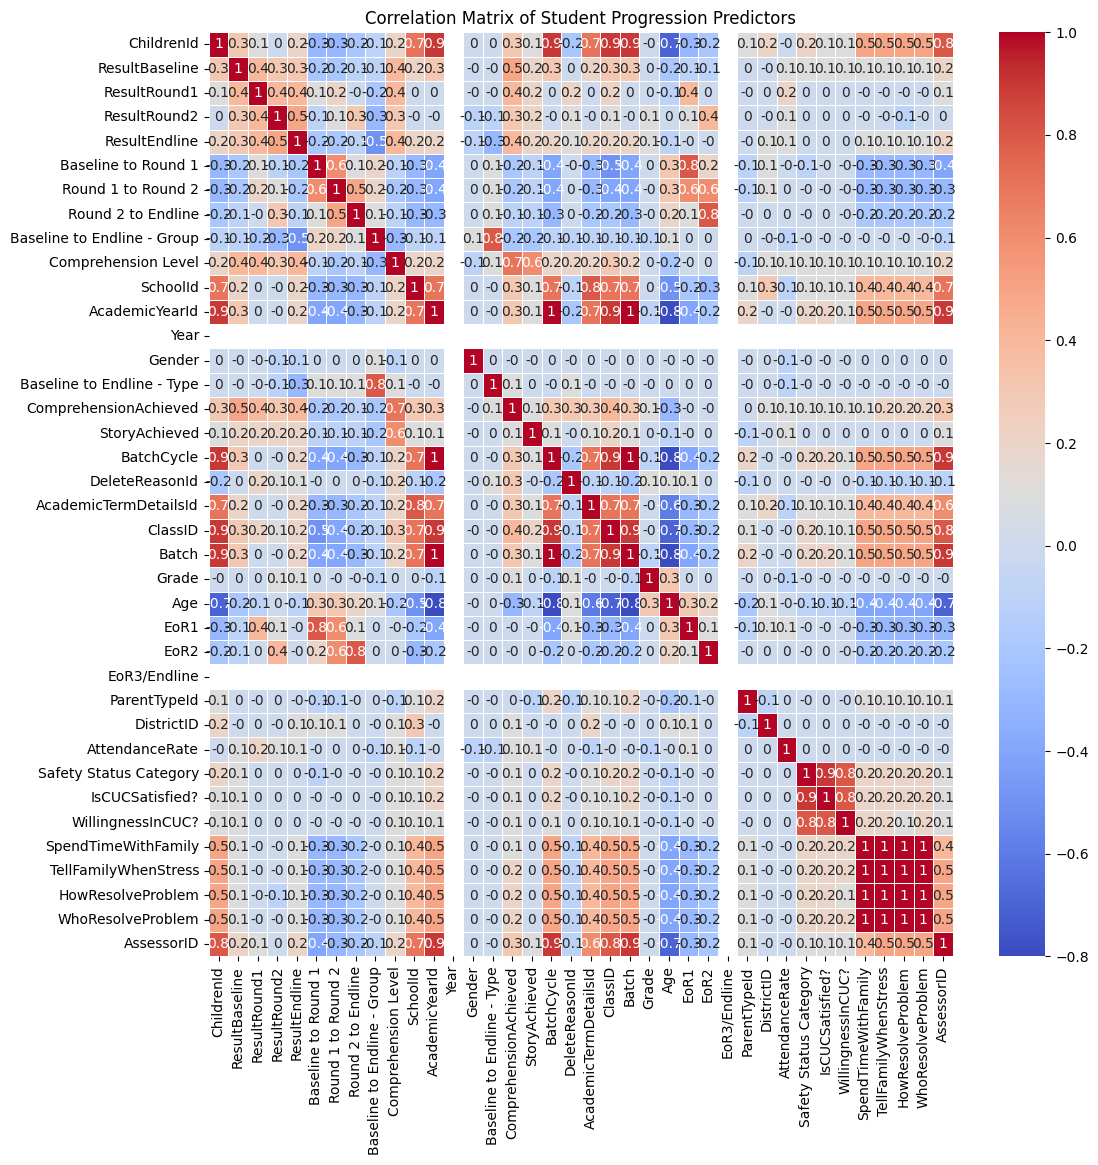

In [56]:
merged_df.rename(columns={'Completing Result Baseline to Endline-Story/Comprehension Level': 'Comprehension Level'}, inplace=True)

# correlation matrix
corr_matrix = merged_df.corr().round(1)
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Student Progression Predictors')
plt.show()

In [57]:
merged_df.columns

Index(['ChildrenId', 'ResultBaseline', 'ResultRound1', 'ResultRound2',
       'ResultEndline', 'Baseline to Round 1', 'Round 1 to Round 2',
       'Round 2 to Endline', 'Baseline to Endline - Group',
       'Comprehension Level', 'SchoolId', 'AcademicYearId', 'Year', 'Gender',
       'Baseline to Endline - Type', 'ComprehensionAchieved', 'StoryAchieved',
       'BatchCycle', 'DeleteReasonId', 'AcademicTermDetailsId', 'ClassID',
       'Batch', 'Grade', 'Age', 'EoR1', 'EoR2', 'EoR3/Endline', 'ParentTypeId',
       'DistrictID', 'AttendanceRate', 'Safety Status Category',
       'IsCUCSatisfied?', 'WillingnessInCUC?', 'SpendTimeWithFamily',
       'TellFamilyWhenStress', 'HowResolveProblem', 'WhoResolveProblem',
       'AssessorID'],
      dtype='object')

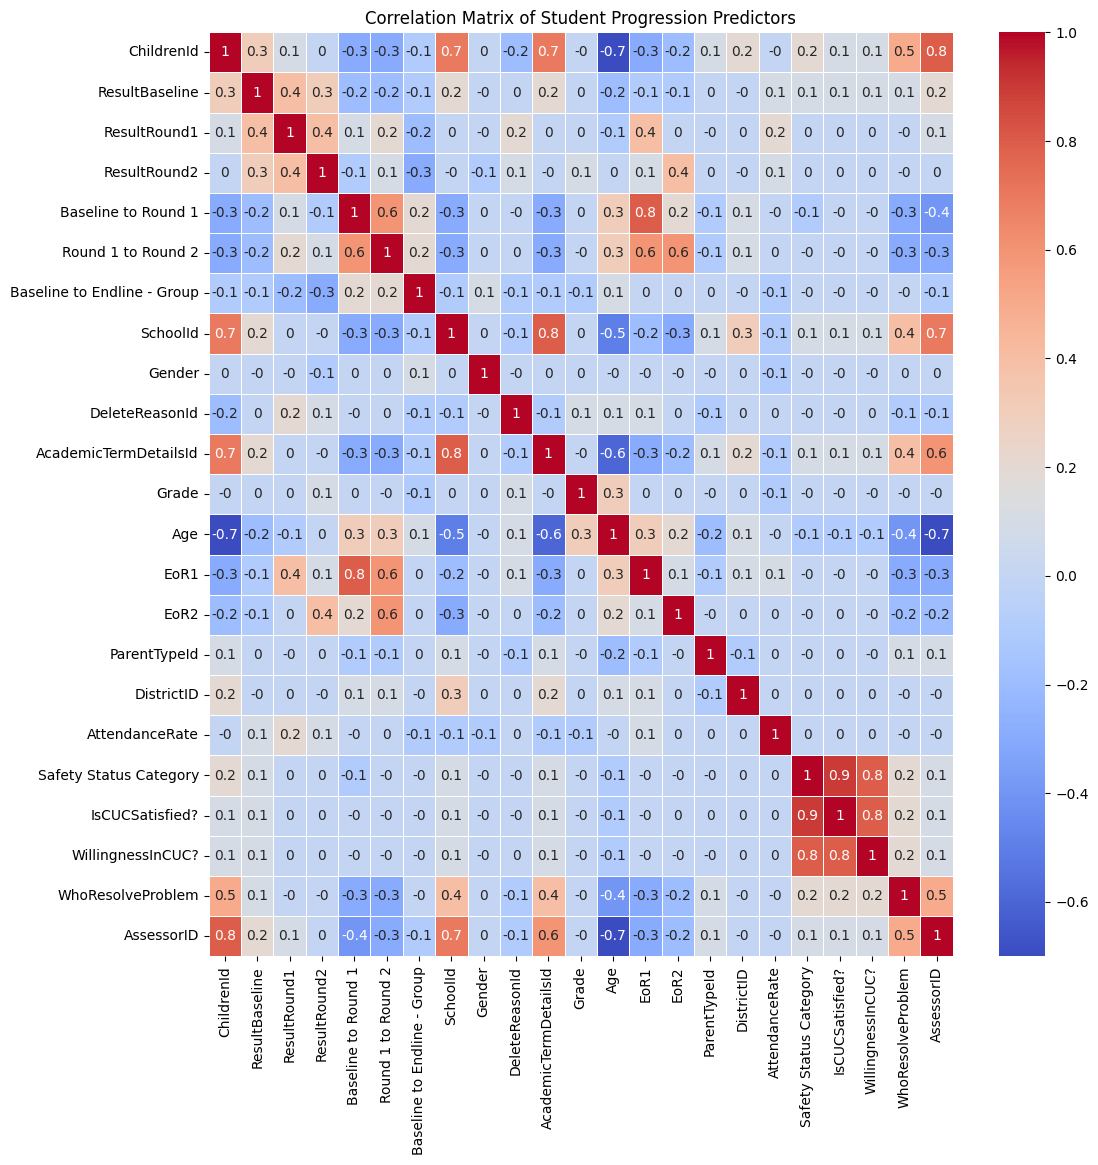

In [59]:
# drop highly inner correlated columns:
cols_drop = [ 'Year', 'EoR3/Endline','SpendTimeWithFamily', 'TellFamilyWhenStress', 'HowResolveProblem', 'BatchCycle', 'Batch', 
             'Baseline to Endline - Type', 'ResultEndline', 'Round 2 to Endline', 'ComprehensionAchieved', 'StoryAchieved', 
             'Comprehension Level', 'AcademicYearId', 'ClassID']

corr_matrix = merged_df.drop(cols_drop, axis=1).corr().round(1)
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Student Progression Predictors')
plt.show()

# Feature importance analysis

In [60]:

# Prepare features (X) and target (y)
y = merged_df['Baseline to Endline - Group'].astype(int)
cols_drop.extend(['Baseline to Endline - Group', 'ChildrenId'])
X = merged_df.drop(cols_drop, axis=1)

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check the shape of train and test data
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (6618, 21), X_test shape: (1655, 21)
y_train shape: (6618,), y_test shape: (1655,)


In [61]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.23      0.29        13
           1       0.80      0.93      0.86      1238
           2       0.59      0.32      0.42       404

    accuracy                           0.77      1655
   macro avg       0.59      0.49      0.52      1655
weighted avg       0.75      0.77      0.75      1655



/Users/assylnur/Desktop/BU/Fall2024/DS701_tools4ds/Spark/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


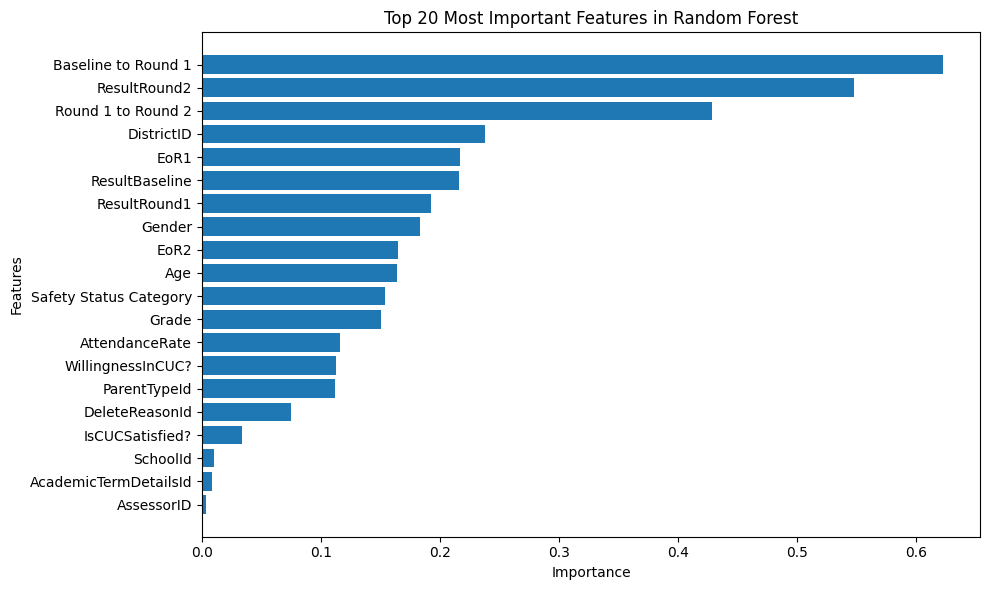

In [62]:
# Extract feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

# Sort by absolute value of the coefficients to see importance
feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot the top 20 features
N = 20
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].head(N), feature_importance['Importance'].head(N),)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Top {N} Most Important Features in Random Forest')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

In [63]:
print(feature_importance)

                   Feature  Coefficient  Importance
3      Baseline to Round 1    -0.622275    0.622275
2             ResultRound2    -0.547819    0.547819
4       Round 1 to Round 2     0.428579    0.428579
14              DistrictID    -0.237813    0.237813
11                    EoR1     0.216829    0.216829
0           ResultBaseline     0.215799    0.215799
1             ResultRound1     0.192095    0.192095
6                   Gender     0.183493    0.183493
12                    EoR2    -0.164710    0.164710
10                     Age    -0.163935    0.163935
16  Safety Status Category     0.153584    0.153584
9                    Grade    -0.150468    0.150468
15          AttendanceRate    -0.116225    0.116225
18       WillingnessInCUC?    -0.112285    0.112285
13            ParentTypeId    -0.111961    0.111961
7           DeleteReasonId    -0.074757    0.074757
17         IsCUCSatisfied?    -0.033345    0.033345
5                 SchoolId    -0.010553    0.010553
8    Academi

In [64]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.95      0.97      0.96      1238
           2       0.88      0.83      0.86       404

    accuracy                           0.93      1655
   macro avg       0.82      0.83      0.83      1655
weighted avg       0.93      0.93      0.93      1655



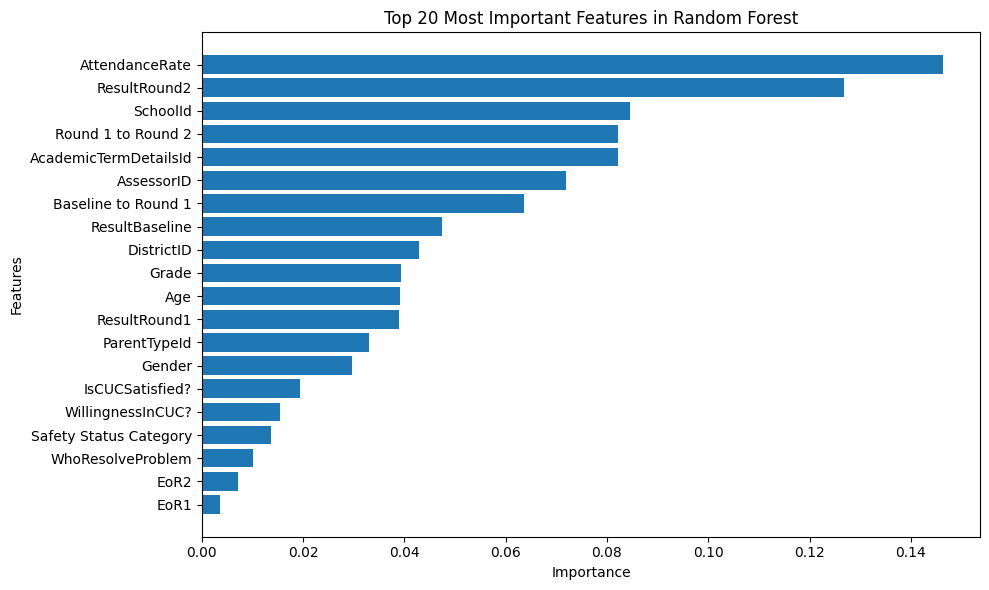

In [65]:
# Get feature importance from the trained model
feature_importance = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)


# Plot the top 20 features
N = 20
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(N), feature_importance_df['Importance'].head(N),)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Top {N} Most Important Features in Random Forest')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()


In [66]:
feature_importance_df

,Feature,Importance
15,AttendanceRate,0.146349
2,ResultRound2,0.126882
5,SchoolId,0.084508
4,Round 1 to Round 2,0.082198
8,AcademicTermDetailsId,0.082120
20,AssessorID,0.071847
3,Baseline to Round 1,0.063532
0,ResultBaseline,0.047447
14,DistrictID,0.042928
9,Grade,0.039366


In [67]:
feature_importance_df.to_excel('data/Ph_FE.xlsx')